In [13]:
import numpy as np
import matplotlib.pyplot as plt
import libmoon
from libmoon.solver.gradient.methods import EPOSolver
from libmoon.util.prefs import get_uniform_pref
from libmoon.problem.synthetic.mop import BaseMOP
from paretoset import paretoset
import torch
torch.set_default_dtype(torch.float32)

In [20]:
# Import grid search data
gridsearchdata = np.load('Data_PositiveNegative_SensitivityPairsParetos.npz')

from pymoo.indicators.gd import GD
from pymoo.indicators.igd import IGD
from pymoo.indicators.hv import HV

In [2]:


import torch
import numpy as np
import matplotlib.pyplot as plt

import libmoon
from libmoon.solver.gradient.methods import EPOSolver
from libmoon.util.prefs import get_uniform_pref
from libmoon.problem.synthetic.mop import BaseMOP

torch.set_default_dtype(torch.float32)



def abs_smooth(z, eps=1e-8):
    return torch.sqrt(z * z + eps)



class XYssNewton(torch.autograd.Function):
    """
    Forward: batched Newton on z=[x,y] to solve F(z; p)=0
    Backward: uses implicit function theorem
      dz/dp = - (∂F/∂z)^{-1} (∂F/∂p)
    and returns dL/dp = (dL/dz) · (dz/dp).
    """

    @staticmethod
    def forward(ctx, beta_x, beta_y, n, it=60, tol=1e-10, damping=1.0):
        # Shapes: all tensors are (B,)
        B = beta_x.shape[0]
        device = beta_x.device
        eps = 1e-12

        # Initial guess (can be adjusted; ones is robust for many cases)
        x = torch.ones(B, device=device)
        y = torch.ones(B, device=device)

        def F_and_J(x, y, bx, by, nn):
            # F
            y_pow_n = torch.pow(y.clamp_min(eps), nn)
            x_pow_n = torch.pow(x.clamp_min(eps), nn)

            F1 = bx / (1.0 + y_pow_n) - x
            F2 = by * (x_pow_n / (1.0 + x_pow_n)) - y

            # ∂F/∂z
            dF1_dx = -1.0
            dF1_dy = -bx * nn * torch.pow(y.clamp_min(eps), nn - 1.0) / torch.pow(1.0 + y_pow_n, 2.0)
            dF2_dx = by * nn * torch.pow(x.clamp_min(eps), nn - 1.0) / torch.pow(1.0 + x_pow_n, 2.0)
            dF2_dy = -1.0

            A = torch.zeros(B, 2, 2, device=device)
            A[:, 0, 0] = dF1_dx
            A[:, 0, 1] = dF1_dy
            A[:, 1, 0] = dF2_dx
            A[:, 1, 1] = dF2_dy

            F = torch.stack([F1, F2], dim=1)  # (B,2)
            return F, A, x_pow_n, y_pow_n

        for _ in range(int(it)):
            F, A, x_pow_n, y_pow_n = F_and_J(x, y, beta_x, beta_y, n)
            # Solve A * step = F  -> step = A^{-1} F
            step = torch.linalg.solve(A, F.unsqueeze(-1)).squeeze(-1)  # (B,2)
            x_new = x - damping * step[:, 0]
            y_new = y - damping * step[:, 1]

            # Convergence check (∞-norm of step)
            if torch.max(torch.max(torch.abs(step[:, 0]), torch.abs(step[:, 1]))) < tol:
                x, y = x_new, y_new
                break
            x, y = x_new, y_new

        # Save for backward
        ctx.save_for_backward(x, y, beta_x, beta_y, n)
        return torch.stack([x, y], dim=1)  # (B,2)

    @staticmethod
    def backward(ctx, grad_out):
        """
        grad_out: dL/dz with shape (B,2), z=[x,y]
        Return: dL/dbeta_x, dL/dbeta_y, dL/dn, and None for it,tol,damping
        """
        x, y, beta_x, beta_y, n = ctx.saved_tensors
        B = beta_x.shape[0]
        device = beta_x.device
        eps = 1e-12

        # Recompute Jacobians at the solution
        x_cl = x.clamp_min(eps)
        y_cl = y.clamp_min(eps)
        x_pow_n = torch.pow(x_cl, n)
        y_pow_n = torch.pow(y_cl, n)
        ln_x = torch.log(x_cl)
        ln_y = torch.log(y_cl)

        # A = ∂F/∂z
        dF1_dx = -1.0
        dF1_dy = -beta_x * n * torch.pow(y_cl, n - 1.0) / torch.pow(1.0 + y_pow_n, 2.0)
        dF2_dx = beta_y * n * torch.pow(x_cl, n - 1.0) / torch.pow(1.0 + x_pow_n, 2.0)
        dF2_dy = -1.0
        A = torch.zeros(B, 2, 2, device=device)
        A[:, 0, 0] = dF1_dx
        A[:, 0, 1] = dF1_dy
        A[:, 1, 0] = dF2_dx
        A[:, 1, 1] = dF2_dy

        # ∂F/∂p for p = [beta_x, beta_y, n]
        # F1 = beta_x/(1+y^n) - x
        dF1_dbx = 1.0 / (1.0 + y_pow_n)
        dF1_dby = torch.zeros_like(dF1_dbx)
        dF1_dn  = -beta_x * (y_pow_n * ln_y) / torch.pow(1.0 + y_pow_n, 2.0)

        # F2 = beta_y * [ x^n / (1 + x^n) ] - y
        dF2_dbx = torch.zeros_like(dF1_dbx)
        dF2_dby = x_pow_n / (1.0 + x_pow_n)
        dF2_dn  = beta_y * (x_pow_n * ln_x) / torch.pow(1.0 + x_pow_n, 2.0)

        Bmat = torch.zeros(B, 2, 3, device=device)
        Bmat[:, 0, 0] = dF1_dbx
        Bmat[:, 0, 1] = dF1_dby
        Bmat[:, 0, 2] = dF1_dn
        Bmat[:, 1, 0] = dF2_dbx
        Bmat[:, 1, 1] = dF2_dby
        Bmat[:, 1, 2] = dF2_dn

        # dz/dp = - A^{-1} * B
        rhs = -Bmat  # (B,2,3)
        dzdp = torch.linalg.solve(A, rhs)  # (B,2,3)

        # dL/dp = (dL/dz)^T * dz/dp
        # grad_out: (B,2); dzdp: (B,2,3) -> (B,3)
        grad_p = torch.einsum('bi,bij->bj', grad_out, dzdp)

        d_bx = grad_p[:, 0]
        d_by = grad_p[:, 1]
        d_n  = grad_p[:, 2]
        return d_bx, d_by, d_n, None, None, None



def S_betax_xss(x, y, beta_x, beta_y, n, eps=1e-12):
    xcl, ycl = x.clamp_min(eps), y.clamp_min(eps)
    num = beta_x * (1 + xcl.pow(n)) * (1 + ycl.pow(n))
    den = (n**2) * beta_x * ycl.pow(n) + xcl * (1 + ycl.pow(n)).pow(2) + xcl.pow(1 + n) * (1 + ycl.pow(n)).pow(2)
    return abs_smooth(num / (den + eps))

def S_betax_yss(x, y, beta_x, beta_y, n, eps=1e-12):
    xcl, ycl = x.clamp_min(eps), y.clamp_min(eps)
    num = n * beta_x * beta_y * xcl.pow(n - 1)
    den = (1 + xcl.pow(n)).pow(2) * ycl + (n**2) * beta_y * xcl.pow(n) * ycl.pow(n) + (1 + xcl.pow(n)).pow(2) * ycl.pow(1 + n)
    return abs_smooth(num / (den + eps))

def S_betay_xss(x, y, beta_x, beta_y, n, eps=1e-12):
    xcl, ycl = x.clamp_min(eps), y.clamp_min(eps)
    num = n * beta_x * (1 + xcl.pow(n)) * ycl.pow(n)
    den = (n**2) * beta_x * ycl.pow(n) + xcl * (1 + ycl.pow(n)).pow(2) + xcl.pow(1 + n) * (1 + ycl.pow(n)).pow(2)
    return abs_smooth((-num) / (den + eps))

def S_betay_yss(x, y, beta_x, beta_y, n, eps=1e-12):
    xcl, ycl = x.clamp_min(eps), y.clamp_min(eps)
    num = beta_x * beta_y * xcl.pow(n - 1) * (1 + xcl.pow(n))
    den = (1 + xcl.pow(n)).pow(2) * ycl + (n**2) * beta_y * xcl.pow(n) * ycl.pow(n) + (1 + xcl.pow(n)).pow(2) * ycl.pow(1 + n)
    return abs_smooth(num / (den + eps))

def S_n_xss(x, y, beta_x, beta_y, n, eps=1e-12):
    xcl, ycl = x.clamp_min(eps), y.clamp_min(eps)
    ln_x, ln_y = torch.log(xcl), torch.log(ycl)
    num = n * beta_x * (n * ln_x + ln_y + ln_y * xcl.pow(n)) * ycl.pow(n)
    den = (n**2) * beta_x * ycl.pow(n) + xcl * (1 + ycl.pow(n)).pow(2) + xcl.pow(1 + n) * (1 + ycl.pow(n)).pow(2)
    return abs_smooth((-num) / (den + eps))

def S_n_yss(x, y, beta_x, beta_y, n, eps=1e-12):
    xcl, ycl = x.clamp_min(eps), y.clamp_min(eps)
    ln_x, ln_y = torch.log(xcl), torch.log(ycl)
    num = n * beta_y * xcl.pow(n) * (ln_x + (ln_x - n * ln_y) * ycl.pow(n))
    den = (1 + xcl.pow(n)).pow(2) * ycl + (n**2) * beta_y * xcl.pow(n) * ycl.pow(n) + (1 + xcl.pow(n)).pow(2) * ycl.pow(1 + n)
    return abs_smooth(num / (den + eps))


OBJECTIVES = {
    "S_betax_xss": S_betax_xss,
    "S_betax_yss": S_betax_yss,
    "S_betay_xss": S_betay_xss,
    "S_betay_yss": S_betay_yss,
    "S_n_xss":     S_n_xss,
    "S_n_yss":     S_n_yss,
}


SELECTED_OBJECTIVES = ("S_betax_xss", "S_betax_yss")


# ---------------------------
# Multi-objective problem
# ---------------------------
class Sensitivity2D_MOP(BaseMOP):
    """
    Decision vars: z = [beta_x, beta_y, n]
      beta_x ∈ [1e-4, 100], beta_y ∈ [1e-4, 100], n ∈ [0.2, 8]
    Objectives: any two from OBJECTIVES
    """
    def __init__(self, obj_names=SELECTED_OBJECTIVES, eps=1e-8):
        super().__init__(n_var=3, n_obj=2, n_cons=0)
        self.obj_names = obj_names
        self.obj_funcs = [OBJECTIVES[nm] for nm in obj_names]
        self.problem_name = "ZDT1"
        self.lbound = torch.tensor([0.01, 0.01, 0.01])
        self.ubound = torch.tensor([50 , 50 , 10])
        self.eps = float(eps)

    def _evaluate_torch(self, z):
        lb = self.lbound.to(z.device)
        ub = self.ubound.to(z.device)
        beta_x = z[:, 0].clamp(lb[0], ub[0])
        beta_y = z[:, 1].clamp(lb[1], ub[1])
        n      = z[:, 2].clamp(lb[2], ub[2])

        # Steady state (x_ss, y_ss) with implicit gradients
        xy = XYssNewton.apply(beta_x, beta_y, n)  # (B,2)
        x, y = xy[:, 0], xy[:, 1]

        # Two objectives
        f1 = self.obj_funcs[0](x, y, beta_x, beta_y, n)
        f2 = self.obj_funcs[1](x, y, beta_x, beta_y, n)

        return torch.stack([f1, f2], dim=1)



Loop hyperparameters

In [7]:
import time
from paretoset import paretoset

In [4]:
# --- Parameter sweeps ---
Epochs_list = (np.linspace(1, 200, num=3)).astype(int)
Samps_list = (np.linspace(1, 200, num=3)).astype(int)

# Storage structure: rows = Samps, cols = Epochs
# ┌───────────────────────────────────────────────┐
# │                Number of Eqpochs (j)          │
# │            Epochs_1  Epochs_2  Epochs_3  ...  │
# ├───────────────────────────────────────────────┤
# │ Samps_1     [None]    [None]    [None]   ...  │
# │ Samps_2     [None]    [None]    [None]   ...  │
# │ Samps_3     [None]    [None]    [None]   ...  │
# │   ...       ...       ...       ...           │
# └───────────────────────────────────────────────┘
R, C     = len(Samps_list), len(Epochs_list)
all_F    = [[None for _ in range(C)] for _ in range(R)]  # objectives (fronts)
all_X    = [[None for _ in range(C)] for _ in range(R)]  # parameters
all_time = np.zeros((R, C), dtype=float)
all_size = np.zeros((R, C), dtype=int)

In [8]:
# --- Optimization loops ---
for i, Samps in enumerate(Samps_list):
    for j, Epochs in enumerate(Epochs_list):

        # Instantiate the problem
        problem = Sensitivity2D_MOP(eps=1e-8)

        # Number of preference vectors (solutions to find); larger K means more coverage of the Pareto front
        K = Samps

        # Generate uniform preference vectors (weights for objectives); Each row sums to 1. 
        prefs = get_uniform_pref(K, 2, clip_eps=1e-2) 

        # Random initialization across the box (alpha, n)
        lb, ub = problem.lbound, problem.ubound
        x0 = lb + torch.rand(K, 3) * (ub - lb)  # random init over the box

        # Gradient-based Pareto optimizer
        solver = EPOSolver(
            step_size=1e-1,   #### learning rate for gradient descent or Size of each optimization step (bigger = faster but riskier)
            n_epoch=Epochs,      #### optimization iterations or number of epochs
            tol=1e-6,         #### early-stop threshold inside EPOSolver. Think of it as the tolerance for convergence
            problem=problem,  #### Optimization problem
            prefs=prefs)      #### Preference weights

        # --- precise CPU timing ---
        t0 = time.process_time()
        res = solver.solve(x_init=x0)
        exec_time_cpu = time.process_time() - t0
        # ---------------------------

        # Extract results
        X_raw = res["x"]  # Optimized alpha, n pairs
        Y_raw = res["y"]  # Sensitivities (S_alpha, S_n)

        # Identify Pareto front using paretoset library
        mask = paretoset(Y_raw, sense=['min', 'min'])
        X = X_raw[mask]
        Y = Y_raw[mask]

        # Store results in grid form
        all_F[i][j] = Y
        all_X[i][j] = X
        all_time[i, j] = exec_time_cpu
        all_size[i, j] = X.shape[0]


# Our final all_F and all_X structures
# ┌───────────────────────────────────────────────┐
# │                 Generation (j)                │
# │           Epochs_1  Epochs_2  Epochs_3  ...   │
# ├───────────────────────────────────────────────┤
# │ Samps_1  [F[0][0]] [F[0][1]] [F[0][2]]  ...   │
# │ Samps_2  [F[1][0]] [F[1][1]] [F[1][2]]  ...   │
# │ Samps_3  [F[2][0]] [F[2][1]] [F[2][2]]  ...   │
# │   ...       ...       ...       ...           │
# └───────────────────────────────────────────────┘

# Conver to numpy array
all_F_np = np.array(all_F, dtype=object)
all_X_np = np.array(all_X, dtype=object)


100%|██████████| 200/200 [01:51<00:00,  1.80it/s]


In [9]:
np.savez(
    "Nam_Data_LibmoonEpo_PosNeg.npz",
    all_F=all_F_np,
    all_X=all_X_np,
    all_time=all_time,
    all_size=all_size,
    Samps_list=Samps_list,
    Epochs_list=Epochs_list,
)

PERFORMANCE METRICS

In [10]:
# Load saved dataset
data = np.load("Nam_Data_LibmoonEpo_PosNeg.npz", allow_pickle=True)

# Check what's inside
print("Available keys:", data.files)

# Retrieve your stored arrays directly
all_F_np     = data["all_F"]
all_X_np     = data["all_X"]
all_time     = data["all_time"]
all_size     = data["all_size"]
Samps_list   = data["Samps_list"]
Epochs_list  = data["Epochs_list"]

# Dimensions
R, C = len(Samps_list), len(Epochs_list)
print("R:", R, "C:", C)

Available keys: ['all_F', 'all_X', 'all_time', 'all_size', 'Samps_list', 'Epochs_list']
R: 3 C: 3


Analysis: evolving Pareto fronts with population size (column wise evolution)

In [11]:
# Evolving Pareto fronts across Samps (rows) for each Epochs (column)
Storage_EvolvingParetos_Samps = np.empty((R, C), dtype=object)
Storage_EvolvingParams_Samps  = np.empty((R, C), dtype=object)

# Loop through Number of Epochs column-wise
for columnnum, Epochs in enumerate(Epochs_list):

    # Get the data for this Number of Epochs across all Sample Sizes
    Fcolumn = all_F_np[:, columnnum]
    Xcolumn = all_X_np[:, columnnum]

    # Column vectors to store sequence of Pareto front & parameter coordinates
    pareto_front_sequence = np.empty(R, dtype=object)
    pareto_param_sequence = np.empty(R, dtype=object)

    # Loop through populations
    for rownum, Samps in enumerate(Samps_list):
        
        # Initialize empty accumulators for this population size
        AllParetoFrontsUpToCurrentSamps = np.empty((0, 2))  # Initialize an empty array
        AllParetoParamsUpToCurrentSamps = np.empty((0, 3))  # Initialize an empty array

        # Accumulate data from the first run up to the current run
        for ind in range(rownum + 1):

            CurrentParetoFront = Fcolumn[ind].astype(float)
            AllParetoFrontsUpToCurrentSamps = np.vstack((AllParetoFrontsUpToCurrentSamps, CurrentParetoFront))

            CurrentParetoParam = Xcolumn[ind].astype(float)
            AllParetoParamsUpToCurrentSamps = np.vstack((AllParetoParamsUpToCurrentSamps, CurrentParetoParam))

        # Compute Pareto-optimal points
        mask = paretoset(AllParetoFrontsUpToCurrentSamps, sense=["min", "min"])
        filteredfront = AllParetoFrontsUpToCurrentSamps[mask]
        filteredparam = AllParetoParamsUpToCurrentSamps[mask]

        # Store Pareto front and pareto parameters for this row
        pareto_front_sequence[rownum] = filteredfront
        pareto_param_sequence[rownum] = filteredparam

    # Store the full column sequence for this generation
    Storage_EvolvingParetos_Samps[:,columnnum] = pareto_front_sequence
    Storage_EvolvingParams_Samps[:,columnnum]  = pareto_param_sequence

In [24]:
gridsearchdata = gridsearchdata['paretoset_SensPair1']

In [25]:
# Preallocate
GDs = np.full(Storage_EvolvingParetos_Samps.shape, np.nan)

# Define indicator once using the reference front
ind = GD(gridsearchdata)

# Loop over epochs × sample sizes
for col, Epochs in enumerate(Epochs_list):
    for row, Samps in enumerate(Samps_list):
        pf = np.asarray(Storage_EvolvingParetos_Samps[row, col], dtype=float)
        GDs[row, col] = ind(pf)

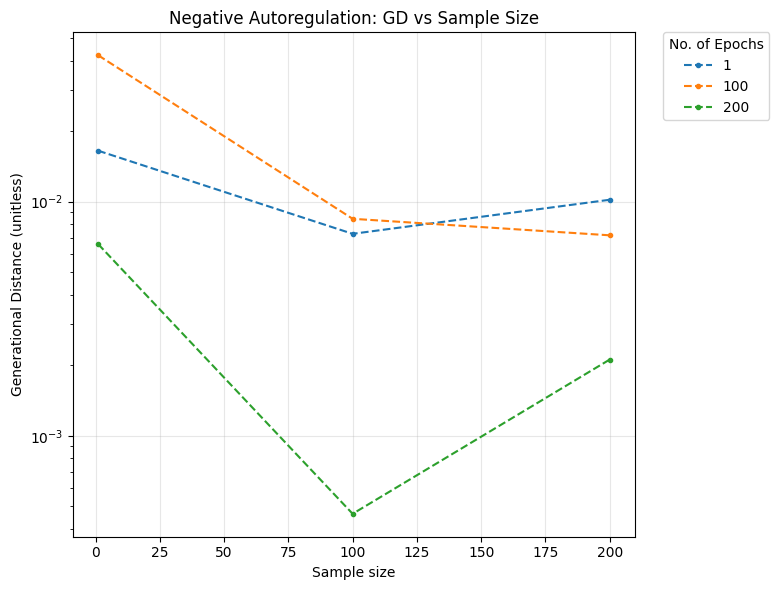

In [26]:
# --- Plot Generational Distance for each generation column ---
plt.figure(figsize=(10,6))

# Loop over each column (generation)
for col, Epochs in enumerate(Epochs_list):
    plt.plot(
        Samps_list, 
        GDs[:, col], 
        marker='.', 
        linestyle='--', 
        label=f'{Epochs}'
    )

plt.xlabel("Sample size")
plt.ylabel("Generational Distance (unitless)")
plt.yscale("log")
plt.title("Negative Autoregulation: GD vs Sample Size")

# --- Place legend outside on the right ---
plt.legend(
    title="No. of Epochs",
    bbox_to_anchor=(1.05, 1),  # x = 1.05 puts it just outside the plot
    loc='upper left',
    borderaxespad=0.
)

plt.grid(alpha=0.3)
plt.tight_layout(rect=[0, 0, 0.8, 1])  # leaves space for the legend
plt.show()

In [27]:
# Preallocate
IGDs = np.full(Storage_EvolvingParetos_Samps.shape, np.nan)

# Define indicator once using the reference front
ind = IGD(gridsearchdata)

# Loop over epochs × sample sizes
for col, Epochs in enumerate(Epochs_list):
    for row, Samps in enumerate(Samps_list):
        pf = np.asarray(Storage_EvolvingParetos_Samps[row, col], dtype=float)
        IGDs[row, col] = ind(pf)

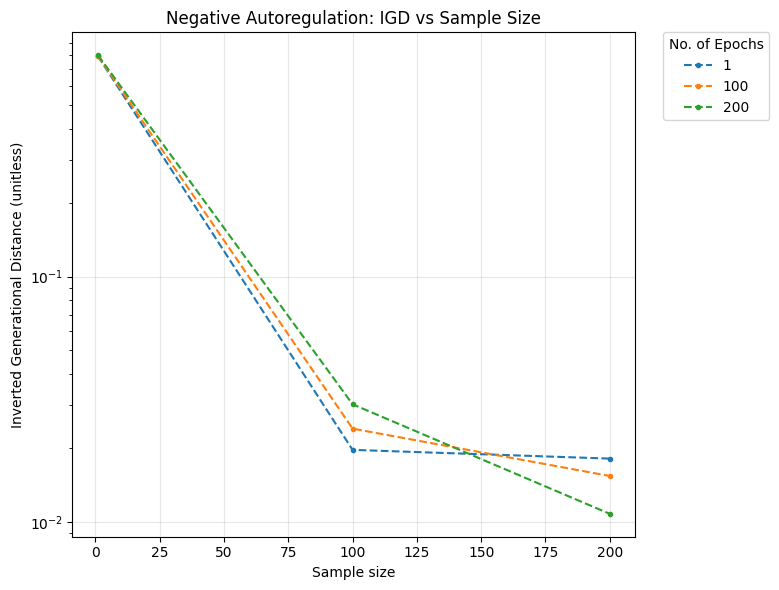

In [28]:
# --- Plot Inverse Generational Distance for each generation column ---
plt.figure(figsize=(10,6))

# Loop over each column (generation)
for col, Epochs in enumerate(Epochs_list):
    plt.plot(
        Samps_list, 
        IGDs[:, col], 
        marker='.', 
        linestyle='--', 
        label=f'{Epochs}'
    )

plt.xlabel("Sample size")
plt.ylabel("Inverted Generational Distance (unitless)")
plt.yscale("log")
plt.title("Negative Autoregulation: IGD vs Sample Size")

# --- Place legend outside on the right ---
plt.legend(
    title="No. of Epochs",
    bbox_to_anchor=(1.05, 1),  # x = 1.05 puts it just outside the plot
    loc='upper left',
    borderaxespad=0.
)

plt.grid(alpha=0.3)
plt.tight_layout(rect=[0, 0, 0.8, 1])  # leaves space for the legend
plt.show()

In [29]:
# --- Reference point based on true Pareto front (t) ---
buffer = 0.10  # 10% buffer beyond true front bounds
t_min = gridsearchdata.min(axis=0)
t_max = gridsearchdata.max(axis=0)
ref_point = t_max + buffer * (t_max - t_min)

hv = HV(ref_point=ref_point)
HV_true = float(hv(gridsearchdata))

# --- Initialize storage ---
HV_grid = np.full(Storage_EvolvingParetos_Samps.shape, np.nan)
HV_ratio = np.full(Storage_EvolvingParetos_Samps.shape, np.nan)

# --- Compute HV for each cell ---
for i in range(Storage_EvolvingParetos_Samps.shape[0]):      # population
    for j in range(Storage_EvolvingParetos_Samps.shape[1]):  # generations
        
        pf = Storage_EvolvingParetos_Samps[i, j]
        if pf is None or len(pf) == 0:
            continue
        
        pf = np.asarray(pf, dtype=float)
        hv_val = float(hv(pf))
        HV_grid[i, j] = hv_val
        HV_ratio[i, j] = hv_val / HV_true if HV_true > 0 else np.nan

print("Reference point:", ref_point)
print(f"True front HV: {HV_true:.6f}")
print("HV grid shape:", HV_grid.shape)
print("HV ratio grid shape:", HV_ratio.shape)

Reference point: [1.09896449 0.11042399]
True front HV: 0.069344
HV grid shape: (3, 3)
HV ratio grid shape: (3, 3)


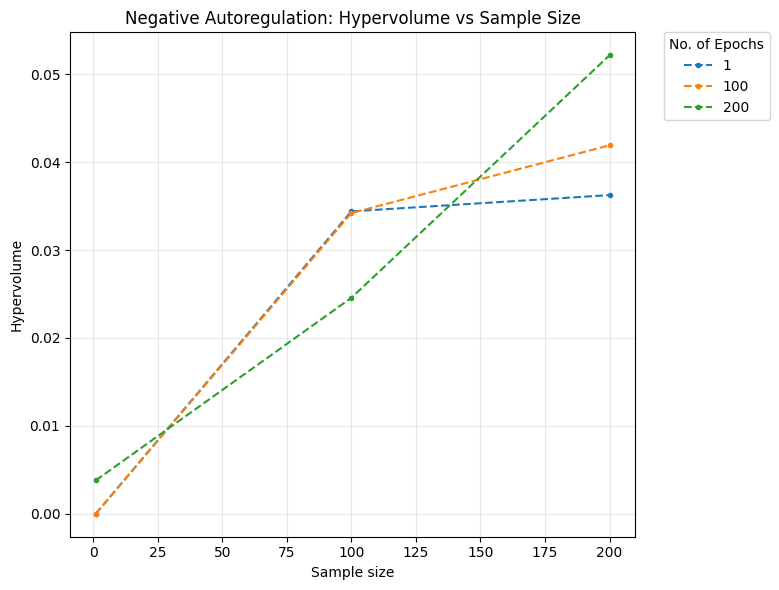

In [30]:
# --- Plot Hypervolume for each generation column ---
plt.figure(figsize=(10,6))

for col, Epochs in enumerate(Epochs_list):
    plt.plot(
        Samps_list,
        HV_grid[:, col],
        marker='.',
        linestyle='--',
        label=f'{Epochs}'
    )

plt.xlabel("Sample size")
plt.ylabel("Hypervolume")
plt.title("Negative Autoregulation: Hypervolume vs Sample Size")

# --- Legend outside the plot ---
plt.legend(
    title="No. of Epochs",
    bbox_to_anchor=(1.05, 1),  # x=1.05 puts legend just outside right edge
    loc='upper left',
    borderaxespad=0.
)

plt.grid(alpha=0.3)
plt.tight_layout(rect=[0, 0, 0.8, 1])  # leave room for legend
plt.show()